# Energy consumption of single household with yearly seasonality

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [78]:
full_data = pd.read_csv("../../data/synthetic/ts_dayly_averaged.csv")
# full_data = pd.read_csv("../../data/synthetic/ts_weekly_averaged.csv")
print(len(full_data))

1442


In [79]:
full_data.head()

,Index,Time,Energy
0,0,16/12/2006,2.487728
1,1,17/12/2006,1.619929
2,2,18/12/2006,1.313087
3,3,19/12/2006,1.207975
4,4,20/12/2006,1.581628


In [80]:
data_frame = full_data.drop(columns=['Index']).copy()

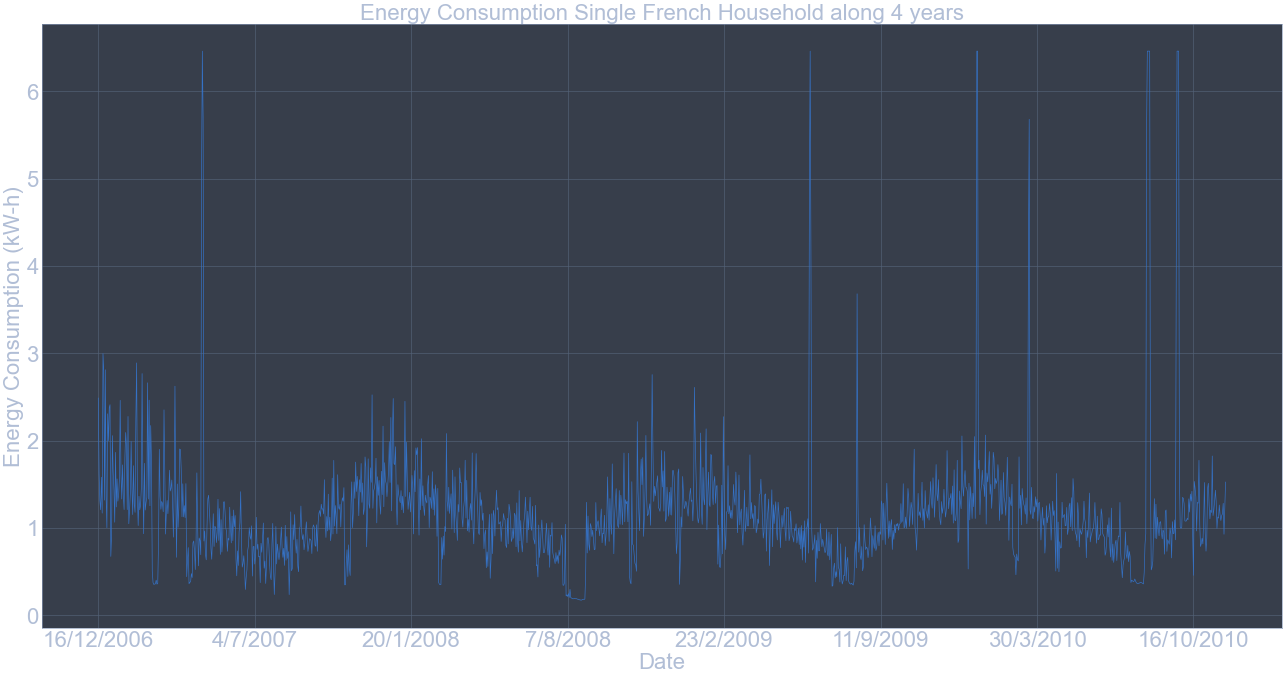

In [81]:
plt.figure(figsize=(40,20), dpi=40)
plt.locator_params(axis='x', nbins=3)
x_ticks = np.arange(0, len(data_frame["Time"]), 200)
plt.xticks(x_ticks)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(data_frame["Time"], data_frame["Energy"])
plt.xlabel("Date", fontsize=40)
plt.ylabel("Energy Consumption (kW-h)", fontsize=40)
plt.title("Energy Consumption Single French Household along 4 years", fontsize=40)
plt.show()

In [82]:
# We observed from the above plot that the trend, seasonality and periodicity can be identified. The irregularity are mostly given by the outliers.

# Rolling Statistics


In [83]:
rollmean = data_frame["Energy"].rolling(window=365).mean()
rollstd = data_frame["Energy"].rolling(window=365).std()
# rollmean = data_frame["Energy"].rolling(window=52).mean()
# rollstd = data_frame["Energy"].rolling(window=52).std()

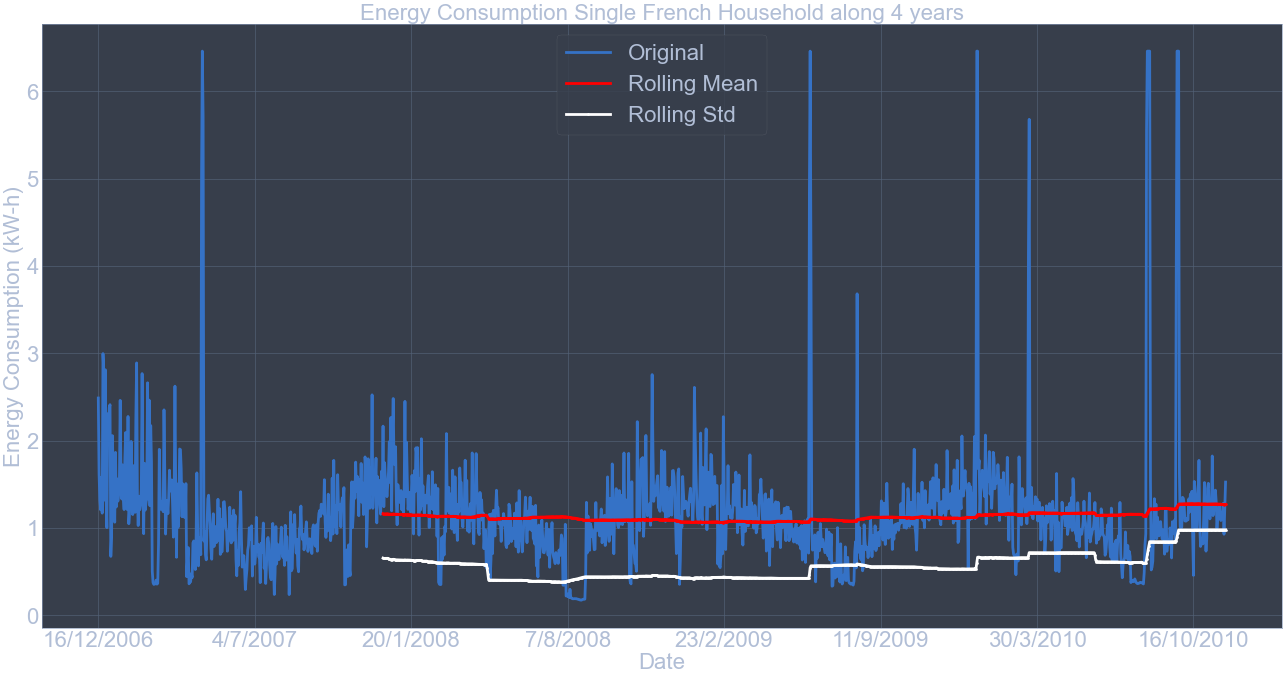

In [84]:
plt.figure(figsize=(40,20), dpi=40)
plt.locator_params(axis='x', nbins=3)
x_ticks = np.arange(0, len(full_data["Time"]), 200)
plt.xticks(x_ticks)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(data_frame["Time"], data_frame["Energy"], label='Original', linewidth='5')
mean = plt.plot(data_frame["Time"], rollmean, '-p', color='red', label='Rolling Mean', linewidth='5')
std = plt.plot(data_frame["Time"], rollstd, '-p', color='white', label='Rolling Std', linewidth='5')
plt.xlabel("Date", fontsize=40)
plt.ylabel("Energy Consumption (kW-h)", fontsize=40)
plt.title("Energy Consumption Single French Household along 4 years", fontsize=40)
plt.legend(loc='best', fontsize=40)
plt.show()

In [85]:
# Also we notice that the data show a stationary behaviour (there is not overall increase or decrease)
# The mean and standard deviation show that there is no significant trend across the yearly seasons

## Outliers treatment

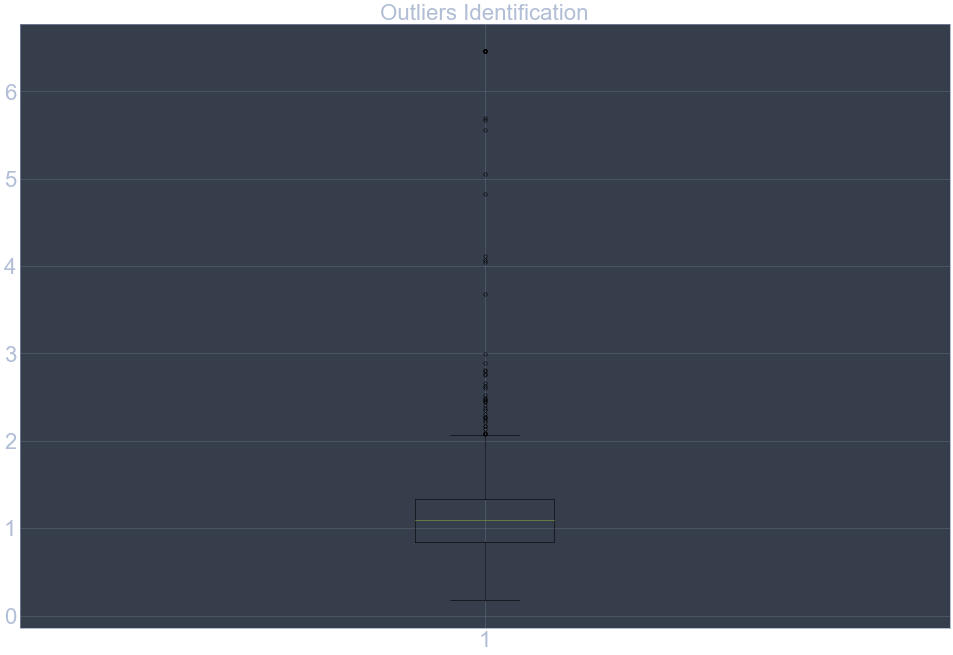

1.1590149882732022


In [86]:
# Find better colors to visualize the boxplot
plt.figure(figsize=(30,20), dpi=40)
plt.boxplot(data_frame['Energy'])
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title("Outliers Identification", fontsize=40)
plt.show()
print(data_frame["Energy"].mean())

In [87]:
energy_cutoff = 3.5
# The following condition returns a boolean array and the sum() call adds only the true conditions
outliers_number = (data_frame["Energy"] > energy_cutoff).sum()
outliers_density = outliers_number/len(data_frame["Energy"])
print(f"The number of outliers is {outliers_number} and the outliers density is: {outliers_density}")

The number of outliers is 20 and the outliers density is: 0.013869625520110958


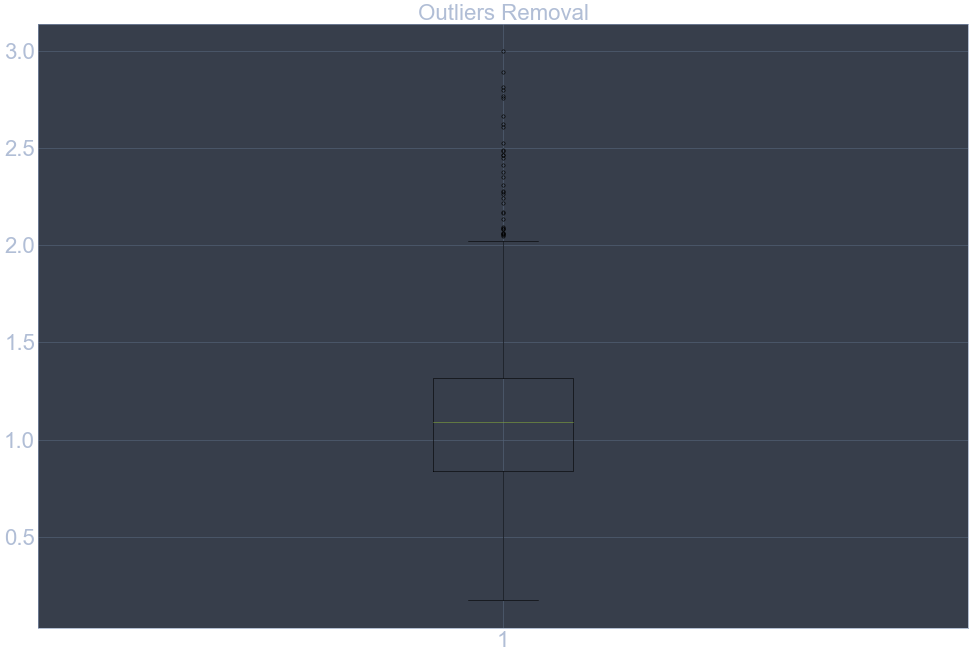

In [88]:
# Outliers removal
data_frame.loc[data_frame.Energy > energy_cutoff, "Energy"] = data_frame["Energy"].mean()
plt.figure(figsize=(30,20), dpi=40)
plt.boxplot(data_frame['Energy'])
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title("Outliers Removal", fontsize=40)
plt.show()

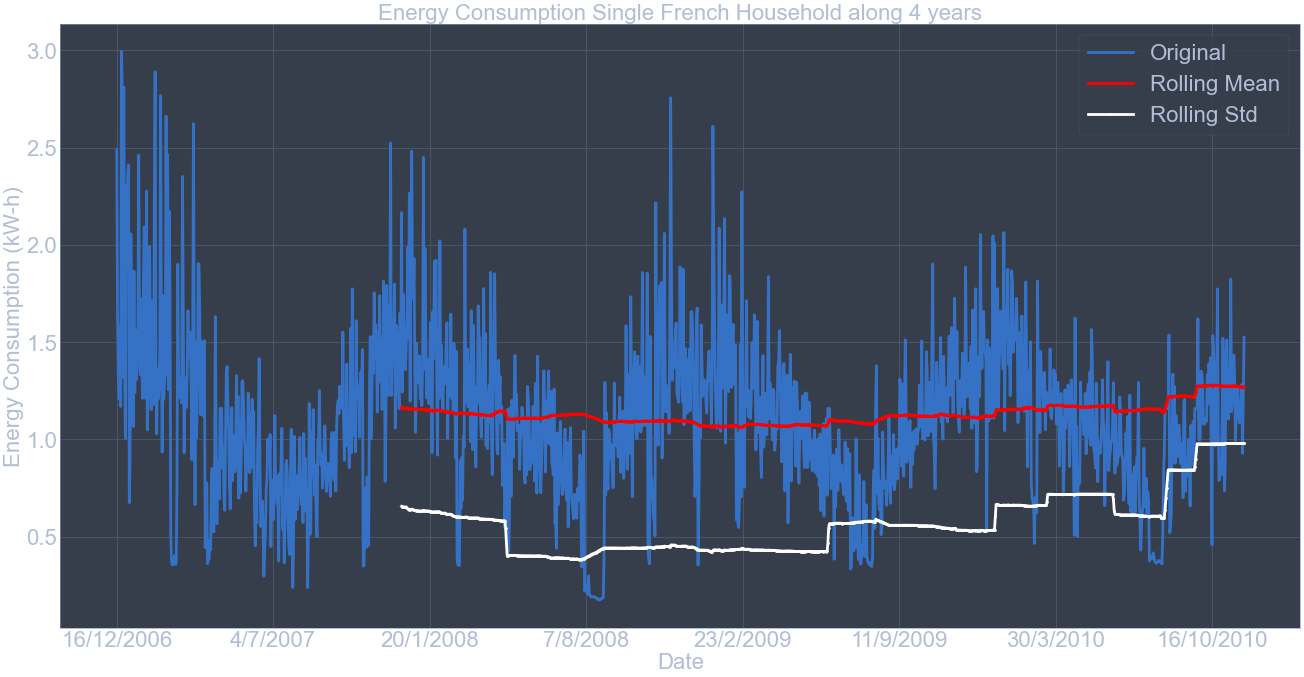

In [89]:
plt.figure(figsize=(40,20), dpi=40)
plt.locator_params(axis='x', nbins=3)
x_ticks = np.arange(0, len(full_data["Time"]), 200)
plt.xticks(x_ticks)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.plot(data_frame["Time"], data_frame["Energy"], label='Original', linewidth='5')
mean = plt.plot(data_frame["Time"], rollmean, '-p', color='red', label='Rolling Mean', linewidth='5')
std = plt.plot(data_frame["Time"], rollstd, '-p', color='white', label='Rolling Std', linewidth='5')
plt.xlabel("Date", fontsize=40)
plt.ylabel("Energy Consumption (kW-h)", fontsize=40)
plt.title("Energy Consumption Single French Household along 4 years", fontsize=40)
plt.legend(loc='best', fontsize=40)
plt.show()

## Normalization, Split and Model Training

In [90]:
# We generate new features from the timestap column
data_frame['Day'] = pd.DatetimeIndex(data_frame['Time'], dayfirst=True).day
data_frame['DayOfWeek'] = pd.DatetimeIndex(data_frame['Time'], dayfirst=True).dayofweek
data_frame['Quarter'] = pd.DatetimeIndex(data_frame['Time'], dayfirst=True).quarter
data_frame['Month'] = pd.DatetimeIndex(data_frame['Time'], dayfirst=True).month
data_frame['Year'] = pd.DatetimeIndex(data_frame['Time'], dayfirst=True).year
data_frame['WeekOfYear'] = pd.DatetimeIndex(data_frame['Time'], dayfirst=True).weekofyear
data_frame['DayOfYear'] = pd.DatetimeIndex(data_frame['Time'], dayfirst=True).dayofyear
y_pre = data_frame.Energy.values
# We will use Standard Scaling because the data is not evenly distributed
scaler = StandardScaler()
y = scaler.fit_transform(y_pre.reshape(-1, 1))
# The size of the training dataset
n_train = 1095   # 3 years (365 * 3 = 1095 days)
# n_train = 156   # 3 years (365 * 3 / 7 = 156 weeks)
data_frame.head()

/tmp/ipykernel_24434/2522672148.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  data_frame['WeekOfYear'] = pd.DatetimeIndex(data_frame['Time'], dayfirst=True).weekofyear


,Time,Energy,Day,DayOfWeek,Quarter,Month,Year,WeekOfYear,DayOfYear
0,16/12/2006,2.487728,16,5,4,12,2006,50,350
1,17/12/2006,1.619929,17,6,4,12,2006,50,351
2,18/12/2006,1.313087,18,0,4,12,2006,51,352
3,19/12/2006,1.207975,19,1,4,12,2006,51,353
4,20/12/2006,1.581628,20,2,4,12,2006,51,354


In [91]:
def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
#    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(40,20))
    x_ticks = np.arange(0, len(full_data["Time"]), 200)
    plt.xticks(x_ticks)
    plt.xticks(fontsize=40)
    # plt.xticks(range(0, len(X_day_month), 200), fontsize=40, rotation=90, ha="left")
    plt.yticks(fontsize=40)
    y_train_reversedScaled = scaler.inverse_transform(y_train.reshape(-1,1))
    y_test_reversedScaled = scaler.inverse_transform(y_test.reshape(-1,1))
    y_pred_reversedScaled = scaler.inverse_transform(y_pred.reshape(-1,1))
    y_pred_train_reversedScaled = scaler.inverse_transform(y_pred_train.reshape(-1,1))
    plt.plot(range(n_train), y_train_reversedScaled, label="train", linewidth=5)
    plt.plot(range(n_train, len(y_test) + n_train), y_test_reversedScaled, '-', label="test", linewidth=5)
    plt.plot(range(n_train), y_pred_train_reversedScaled, '--', label="prediction train", linewidth=5)
    plt.plot(range(n_train, len(y_test) + n_train), y_pred_reversedScaled, '--', label="prediction test", linewidth=5)
    plt.xlabel("Date", fontsize=40)
    plt.ylabel("Energy Consumption (kW-h)", fontsize=40)
    plt.title("Energy Consumption Single French Household along 4 years", fontsize=40)
    plt.legend(loc=(0.7,0.7), fontsize=40)
    print("The mean absolute error is:", mean_absolute_error(y_test, y_pred))
    print("The mean squared error is:", mean_squared_error(y_test, y_pred))
    print("The median absolute error is:", median_absolute_error(y_test, y_pred))
    # print("The r2 score is:", median_absolute_error(y_test, y_pred))

The mean absolute error is: 0.5198980244058802
The mean squared error is: 0.47866486797860225
The median absolute error is: 0.3904551817041245


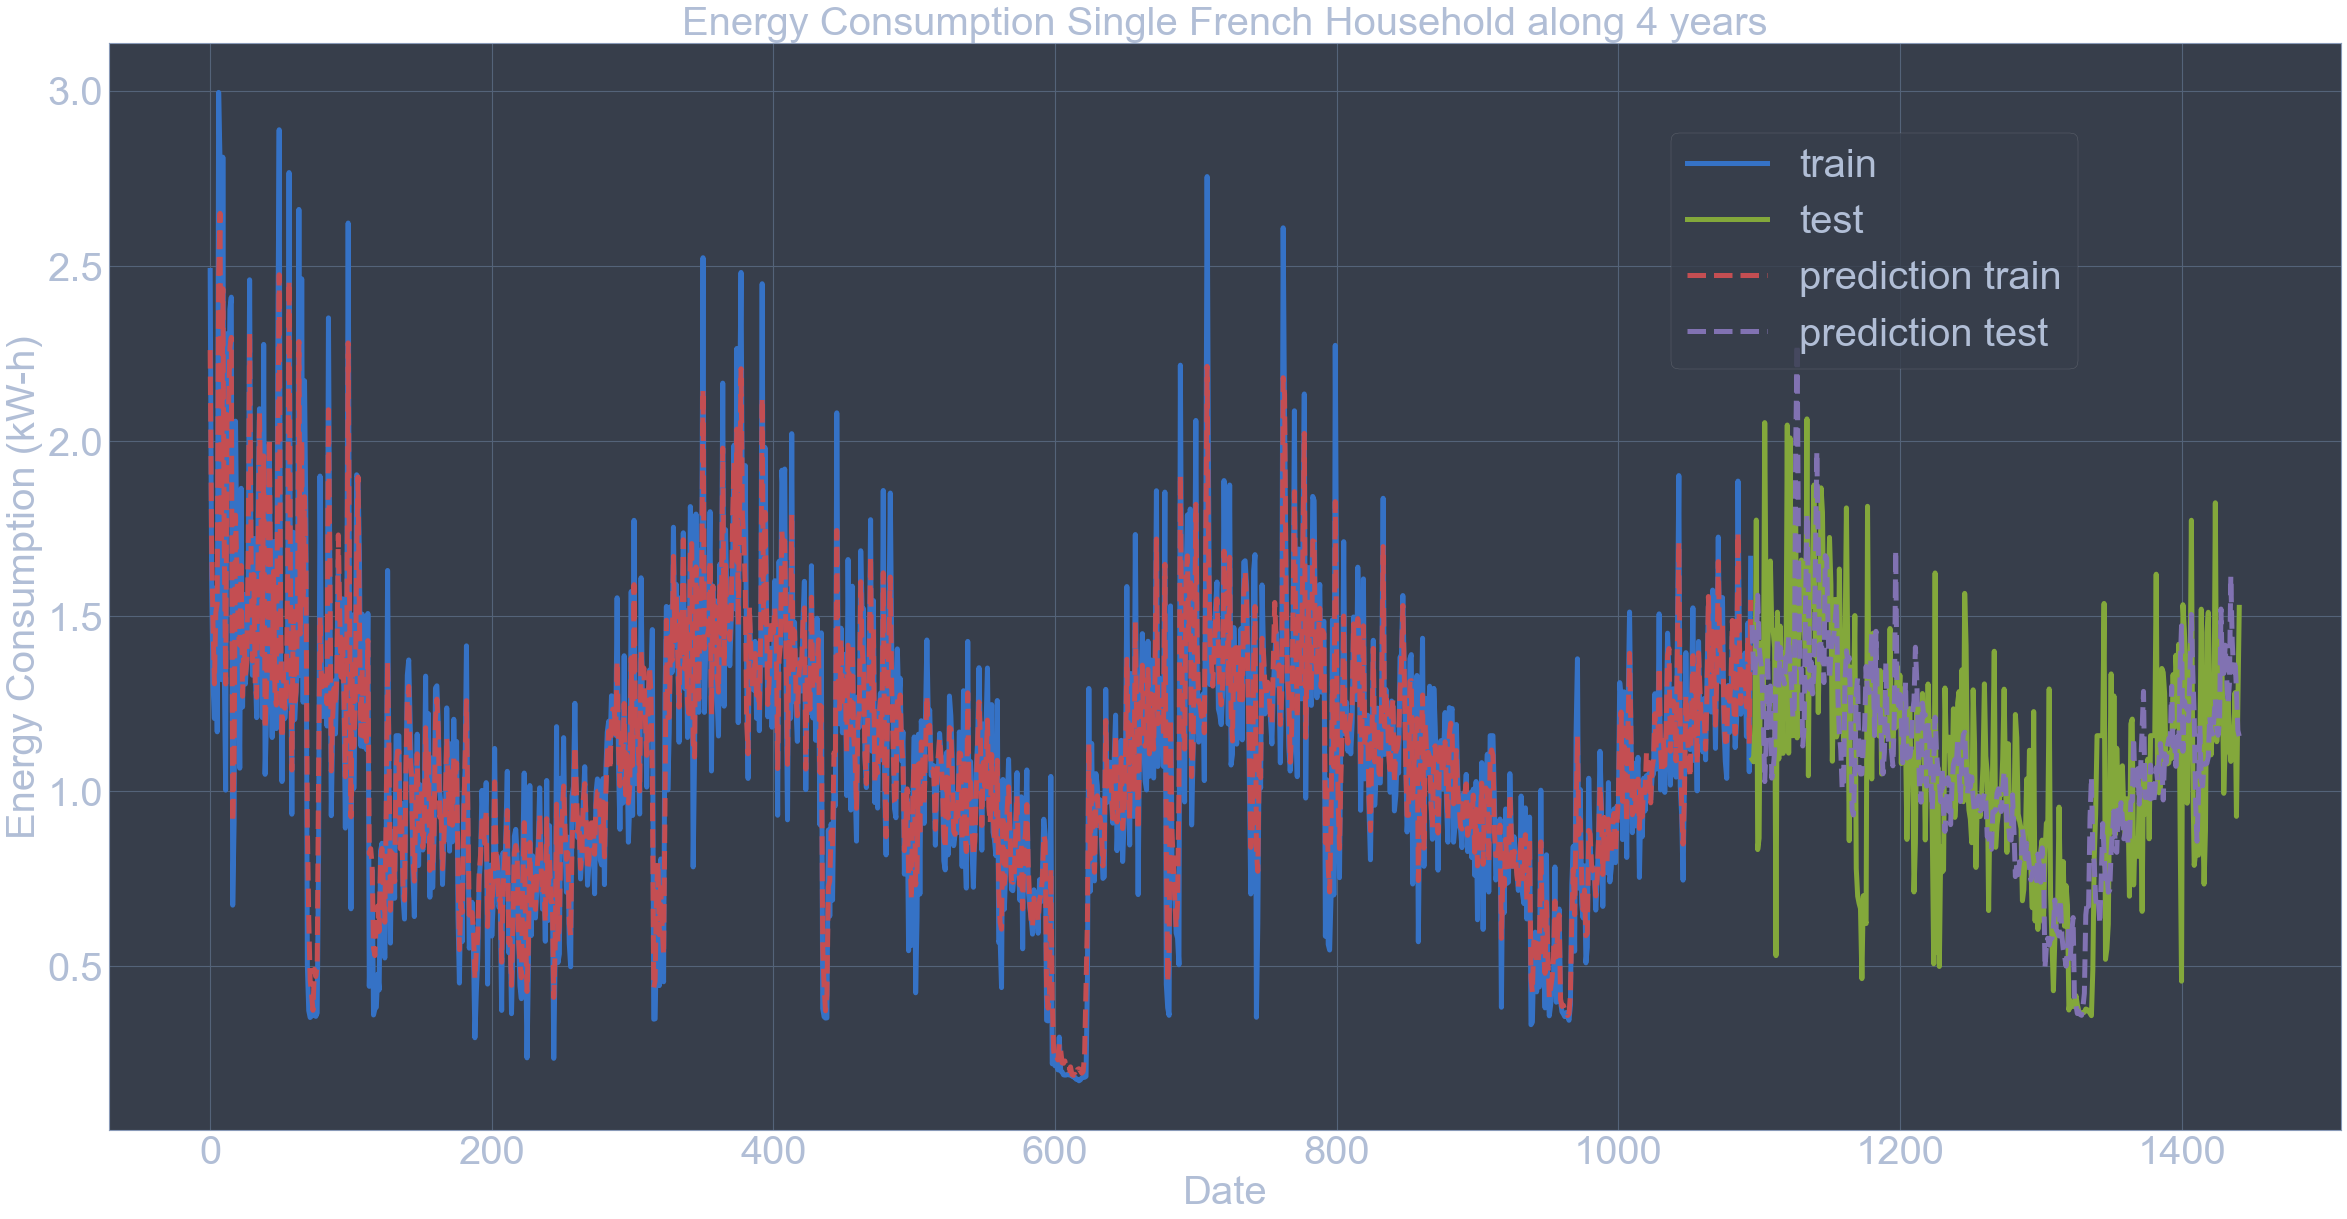

In [92]:
# Model training
X_day_month = np.hstack([data_frame.Day.values.reshape(-1,1), 
                         data_frame.DayOfWeek.values.reshape(-1,1),
                         data_frame.Quarter.values.reshape(-1,1),
                         data_frame.Month.values.reshape(-1,1),
                         data_frame.Year.values.reshape(-1,1),
                         data_frame.WeekOfYear.values.reshape(-1,1),
                         data_frame.DayOfYear.values.reshape(-1,1)])
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X_day_month, y.ravel(), regressor)


The mean absolute error is: 0.5921186120156365
The mean squared error is: 0.5804964186761804
The median absolute error is: 0.4751486460317629


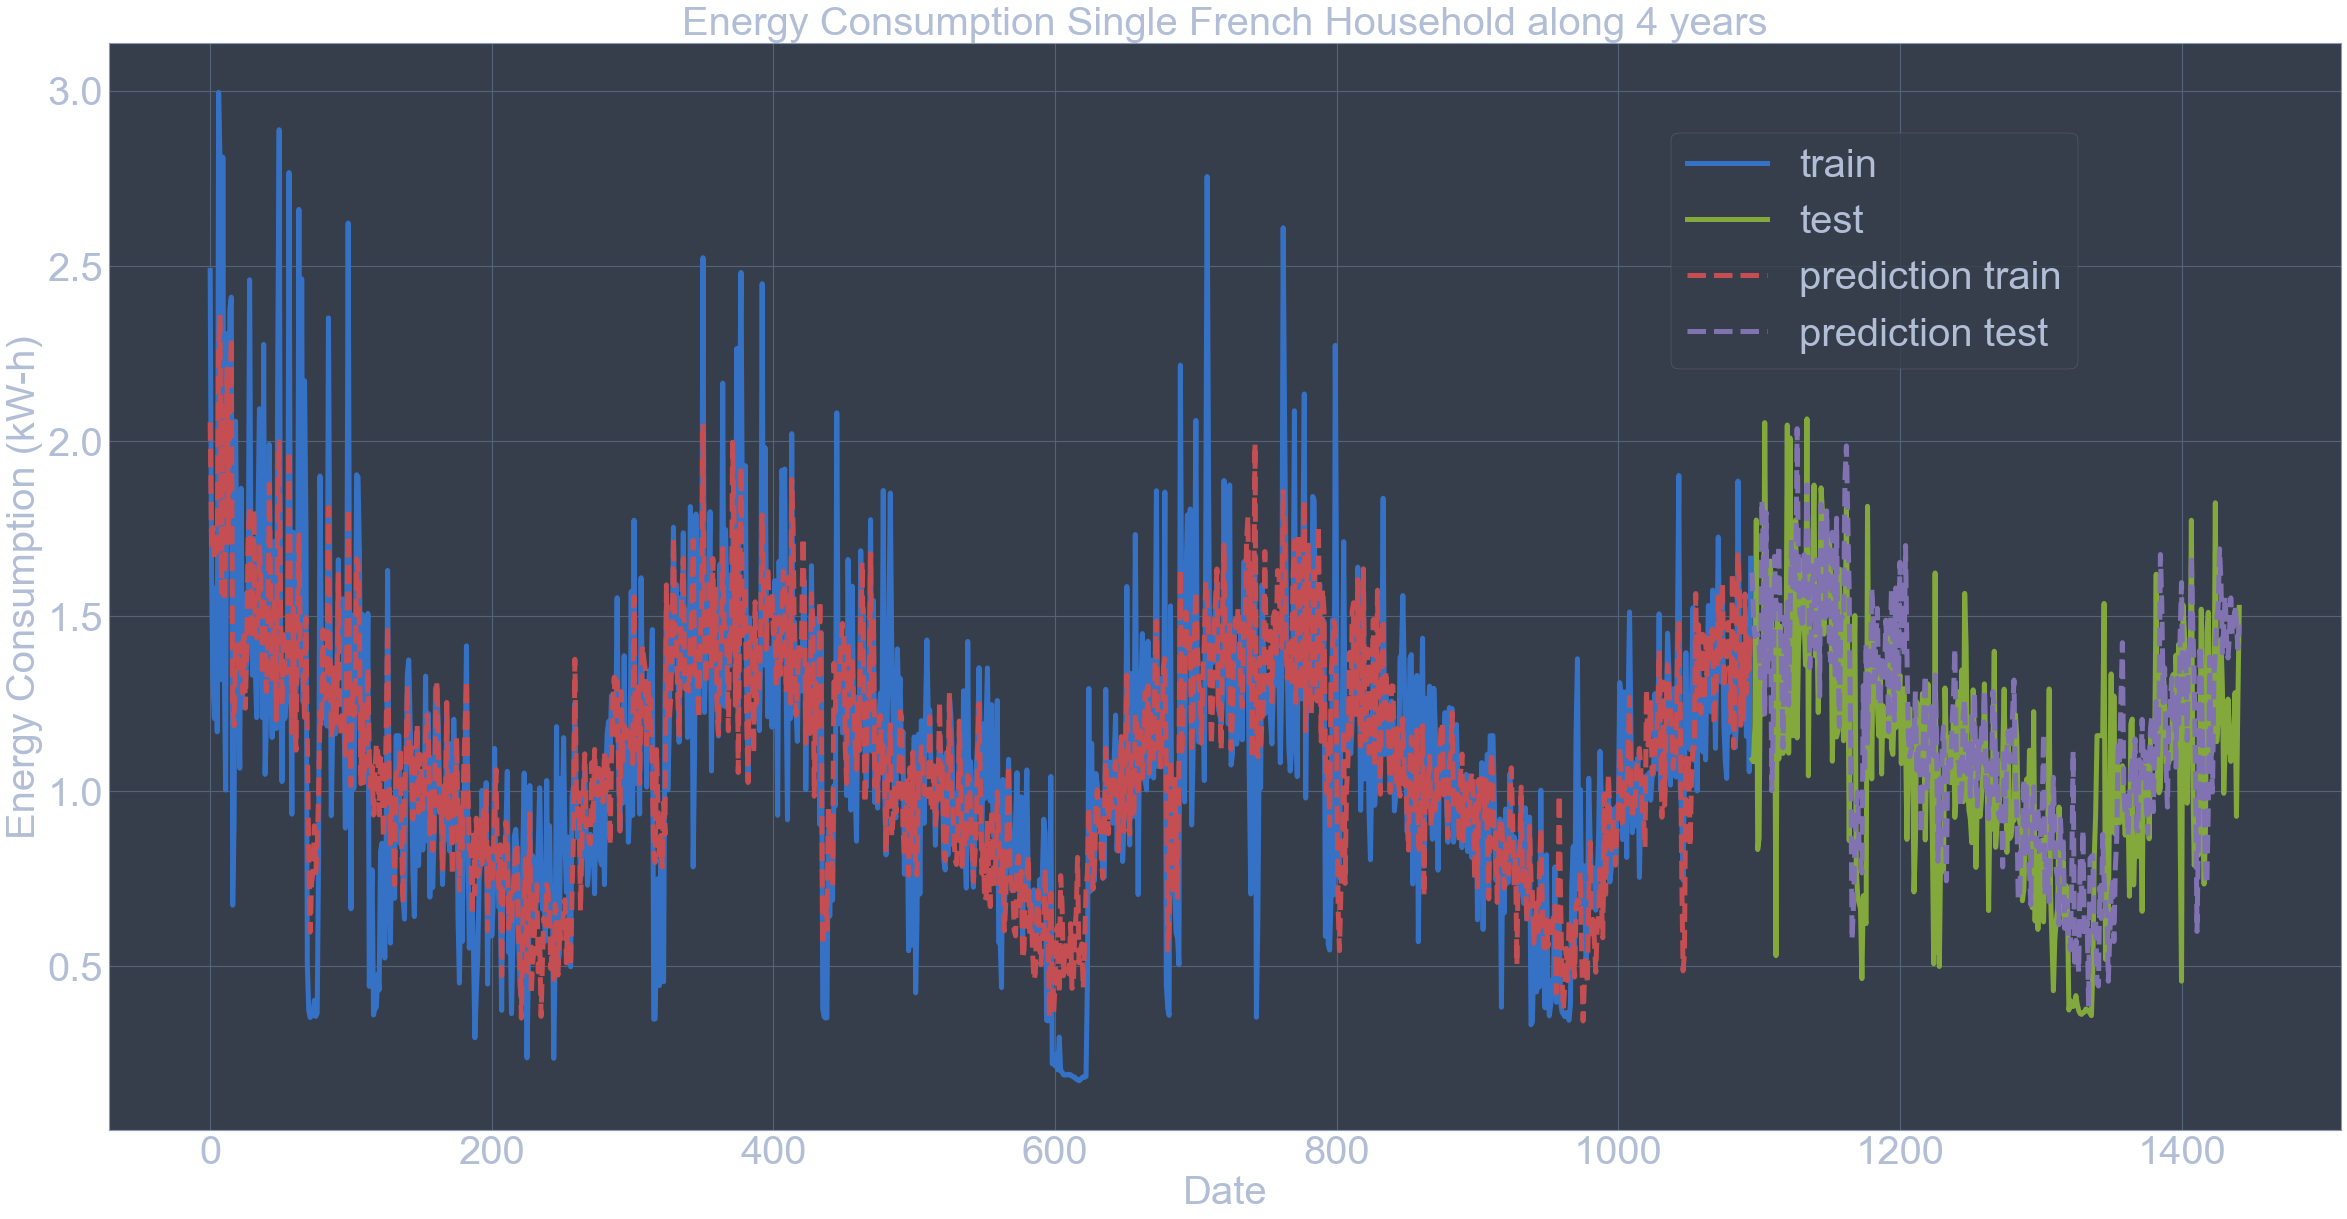

In [93]:
enc = OneHotEncoder()
X_day_month_onehot = enc.fit_transform(X_day_month).toarray()
eval_on_features(X_day_month_onehot, y.ravel(), Ridge())

## Conclusion
- The mean absolute error is ideal, specially because the normalized values of the energy can become negative
- The data has quite a bit variance even after